# Test checker une clé dans un dictionnaire

In [11]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter
import multiprocessing as mp

def log(message, should_log=True):
    if should_log:
        print(message)
    else:
        pass

def log_timer(process_name, should_log=True):
    log(f"Starting {process_name}", should_log=should_log)
    start = time.time()

    def end_timer():
        end = time.time()
        sec = end - start
        mili = sec * 1000
        micro = mili * 1000

        log(f"{process_name} took {sec} s | {mili} ms | {micro} µs", should_log=should_log)
        return end - start

    return end_timer

def find_low(n):
    """
    230 -> 100, 2400 -> 1000 
    """
    s = str(n)
    new_str = '1' + '0' * len(s[1:])
    return int(new_str)

def log_axis(start, end):
    cursor = start
    x_axis = []
    while cursor < end:
        step_size = find_low(cursor)
        cursor_next = step_size * 10
        x_axis = x_axis + list(range(cursor, cursor_next, step_size))

        cursor = cursor_next
    return x_axis

def plot_test(x_axis_lim, dico_task, create_data_func, task_name_denominateur=None):
    start, end = x_axis_lim
    x_axis = log_axis(start, end)
    plots = {task_name: [] for task_name in dico_task}

    for n in x_axis:
        data = create_data_func(n)
        for task_name in dico_task:
            timer = log_timer(task_name, should_log=False)
            task = dico_task[task_name]
            task(data)
            plots[task_name].append(timer())

    def plot_ratio(num, denom):
        result = []
        for i, v in enumerate(denom):
            result.append(num[i] / denom[i])
        return result
    
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    for task_name in dico_task:
        plt.plot(x_axis, plots[task_name], label=task_name)
    plt.xlabel("n elements")
    plt.ylabel("time (s)")
    plt.xscale('log')
    plt.legend()

    plt.subplot(122)
    denominateur = plots[task_name_denominateur if task_name_denominateur else list(dico_task.keys())[0]]
    for task_name in dico_task:
        plt.plot(x_axis, plot_ratio(plots[task_name], denominateur), label=task_name)
    plt.xlabel("n elements")
    plt.ylabel("ratio")
    plt.xscale('log')

    plt.legend()
    plt.show()


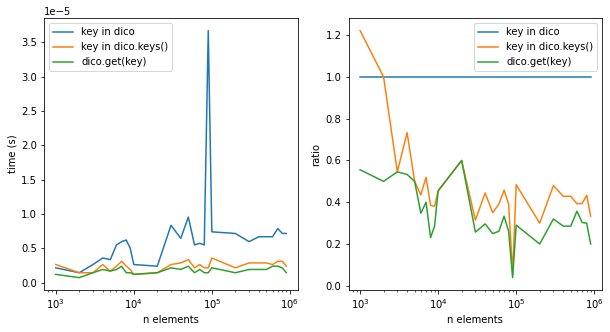

In [13]:
key = "1000"
dico_task = {
    "key in dico": lambda dico: key in dico,
    "key in dico.keys()": lambda dico: key in dico.keys(),
    "dico.get(key)": lambda dico: dico.get(key),
}

plot_test([1000, 1000 * 1000], dico_task, create_data_func=lambda n: {str(i): i for i in range(n)})
# plot_test("1000", 1000, 1000 * 1000)

# Checker une key via dico.get(key) prend environ 25% du temps d'un key in dico pour 1M de lignes

# Testing Multiprocessing

# Test Multiprocessing sur des array normaux

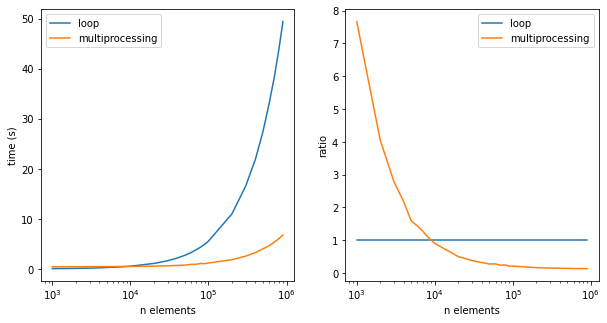

In [14]:
    
def parallel(func, iterable):
    n_cores = mp.cpu_count()
    pool = mp.Pool(n_cores)
    pool.map(func, iterable)
    pool.close()
    pool.join()

def J(x):
    time.sleep(1e-9)
    return x ** 2

dico_task = {
    "loop": lambda data: [J(x) for x in data],
    "multiprocessing": lambda data: parallel(J, data)
}
plot_test([1000, 1000 * 1000], dico_task, create_data_func=lambda n: range(n))

# import concurrent
# timer = log_timer("executor")
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     results = executor.map(J, test)
#     print([x for x in results][0:2])
#     # for f in concurrent.futures.as_completed(results):
#         # print(results)
# timer()



# Test Multiprocessing sur des dataframes

n_cores=8


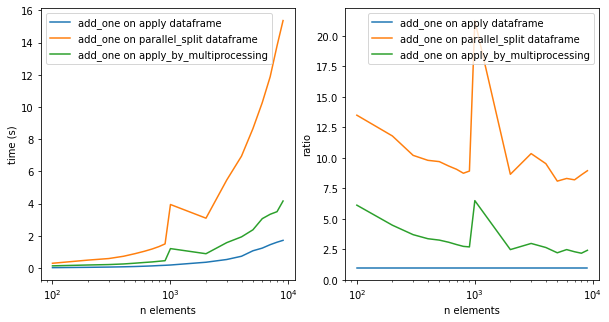

In [13]:
import multiprocessing as mp
import numpy as np
import pandas as pd

# https://www.machinelearningplus.com/python/parallel-processing-python/

n_cores = mp.cpu_count()
print(f"{n_cores=}")


def apply_on_df(df_split, func):
    """
    Wrapper pour appliquer un apply sur un des df splitté de pool parallel_split
    """
    return df_split.apply(func)

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # https://gist.github.com/yong27/7869662
    workers = n_cores
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))

def parallel_split(df, func):
    with mp.Pool(n_cores) as pool:
        split_df = np.array_split(df, n_cores, axis=0)
        result = [pool.apply(apply_on_df, args=(df, func)) for df in split_df]
    result = pd.concat(result)

def add_one(row):
    # print(f"shape={row.shape}")
    # time.sleep(1e-4)
    return row + 1


dico_task = {
    "add_one on apply dataframe": lambda df: df.apply(add_one),
    "add_one on parallel_split dataframe":lambda df: parallel_split(df, add_one),
    "add_one on apply_by_multiprocessing": lambda df: apply_by_multiprocessing(df, add_one)
}
plot_test([100, 10 * 1000], dico_task, 
    create_data_func=lambda n:pd.DataFrame([
            {str(i): i for i in range(n)} for _ in range(1000)
        ])
)



# Test pour rechercher les valeurs du DF dans une liste d'éléments

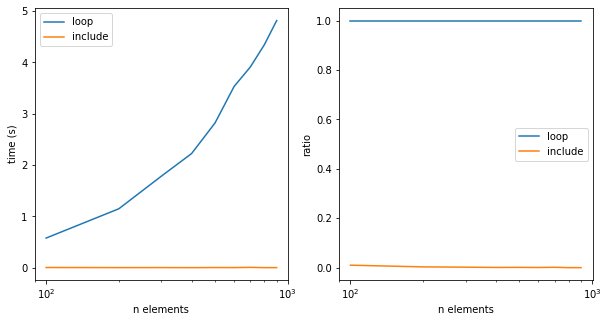

In [6]:
test = [{"name": str(i), "value": i} for i in range(100 * 1000)]
test = pd.DataFrame(test)

def loop_search(search_in):
    for x in search_in:
        test.loc[test.name == x]

dico_task = {
    "loop": lambda data: loop_search(search_in),
    "include": lambda data: test.loc[test.name.isin(search_in)].shape[0]
}

plot_test([100, 1000], dico_task, create_data_func=lambda n: [str(i) for i in range(n)])

# Il est beaucoup plus rapide de faire une seule recherche isin plutôt que de faire une loop

# Test swifter

Pandas Apply: 100%|██████████| 900000/900000 [00:00<00:00, 1329114.86it/s]


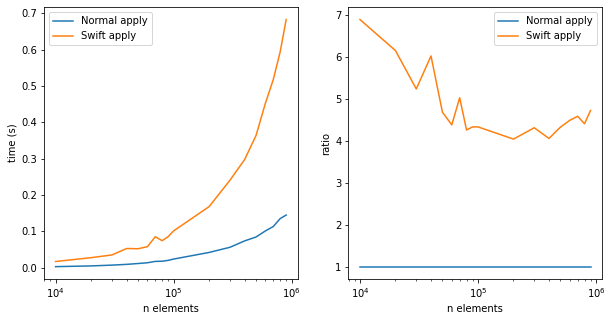

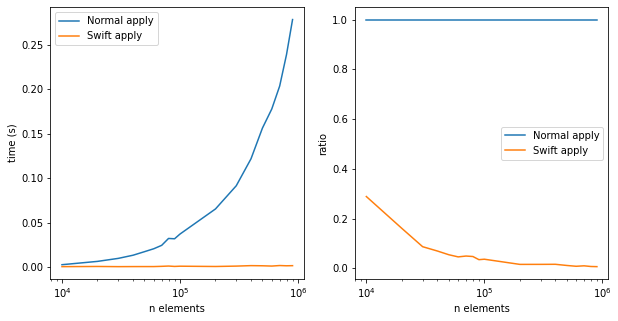

In [9]:

values = ['a', 'b', 'c']

def add(value):
    # fonction que swifter ne vectorise pas
    return values[value % 3]

def add_vectorized(value):
    return value + 1

def add_sleep(value):
    time.sleep(1e-9)
    add(value)


plot_test([10 * 1000, 1000 * 1000],
    dico_task={
        "Normal apply": lambda data: data.value.apply(add),
        "Swift apply": lambda data: data.value.swifter.apply(add)
    }, 
    create_data_func=lambda n: pd.DataFrame([
            {"name": str(i), "value": i} for i in range(n)
        ])
)

plot_test([10 * 1000, 1000 * 1000],
    dico_task={
        "Normal apply": lambda data: data.value.apply(add_vectorized),
        "Swift apply": lambda data: data.value.swifter.apply(add_vectorized)
    }, 
    create_data_func=lambda n: pd.DataFrame([
            {"name": str(i), "value": i} for i in range(n)
        ])
)
